In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Libraries 

In [11]:
!pip install tensorboard

In [23]:
!pip install tensorboard pyngrok

In [24]:
import os
import subprocess
from pyngrok import ngrok
from torch.utils.tensorboard import SummaryWriter

# Step 3: Initialize TensorBoard SummaryWriter
LOG_DIR = 'runs/experiment'

In [34]:
import shutil

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import classification_report
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

In [13]:
import torch.nn.utils.prune as prune
import torch.quantization

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [12]:
from torch.utils.tensorboard import SummaryWriter


2024-05-30 14:05:01.153505: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 14:05:01.153623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 14:05:01.294660: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cuda')

# Load Dataset

In [6]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

In [7]:
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'

In [8]:
root_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'

In [9]:
from PIL import Image
import os

def find_corrupted_images(root_dir):
    corrupted_images = []
    for root, _, files in os.walk(root_dir):
        for file in files:
            try:
                img = Image.open(os.path.join(root, file))
                img.verify()  # Verify that it is, in fact, an image
            except (IOError, SyntaxError) as e:
                corrupted_images.append(os.path.join(root, file))
    return corrupted_images

corrupted_images = find_corrupted_images('path_to_your_dataset')
print(f"Found {len(corrupted_images)} corrupted images.")


Found 0 corrupted images.


In [10]:
phase = ['train','val','test']

In [11]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in phase}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=100,
                                             shuffle=True, num_workers=0)
              for x in phase}
dataset_sizes = {x: len(image_datasets[x]) for x in phase}
class_names = image_datasets['train'].classes

In [12]:
dataloaders['train']

In [13]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 5216
    Root location: /kaggle/input/chest-xray-pneumonia/chest_xray/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
           )

In [14]:
print(f'Total number of classes : {len(class_names)}')

Total number of classes : 2


In [15]:
class_names

['NORMAL', 'PNEUMONIA']

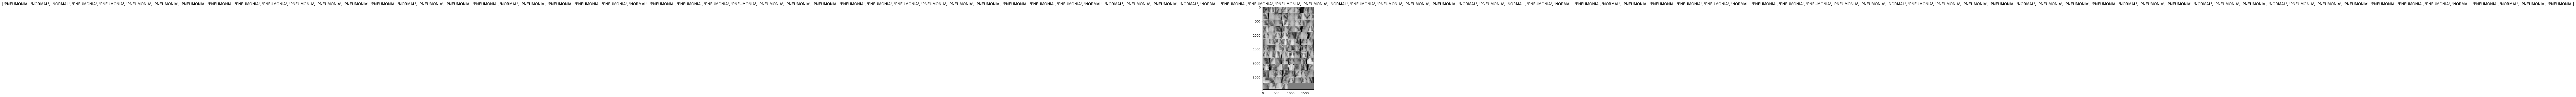

In [16]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [17]:
y_true = []
for inputs, labels in image_datasets['test']:
    y_true.append(labels)
y_true = np.array(y_true)
#print(all_test_images.shape) 

In [18]:
image_datasets['test']

Dataset ImageFolder
    Number of datapoints: 624
    Root location: /kaggle/input/chest-xray-pneumonia/chest_xray/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
           )

In [19]:
class Callback:
    def on_epoch_begin(self, epoch, logs=None):
        pass
    
    def on_epoch_end(self, epoch, logs=None):
        pass
    
    def on_train_begin(self, logs=None):
        pass
    
    def on_train_end(self, logs=None):
        pass

class EarlyStopping(Callback):
    def __init__(self, patience=10, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def on_epoch_end(self, epoch, logs=None):
        current_score = logs.get('val_acc')
        if self.best_score is None:
            self.best_score = current_score
        elif current_score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = current_score
            self.counter = 0

In [2]:
def train_model(model, criterion, optimizer, scheduler,num_epochs=25, callbacks=[]):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initialize callbacks
    for callback in callbacks:
        callback.on_train_begin()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        logs = {}

        # Each epoch has a training and validation phase
        for phs in ['train', 'val']:
            if phs == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phs]:
                #inputs = inputs.to(device)
                #labels = labels.to(device)

                # Forward
                with torch.set_grad_enabled(phs == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phs == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phs == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phs]
            epoch_acc = running_corrects.double() / dataset_sizes[phs]

            logs[f'{phs}_loss'] = epoch_loss
            logs[f'{phs}_acc'] = epoch_acc

            print(f'{phs} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phs == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # Callbacks at the end of epoch
        for callback in callbacks:
            callback.on_epoch_end(epoch, logs)

        # Early stopping check
        if any([cb.early_stop for cb in callbacks if isinstance(cb, EarlyStopping)]):
            print("Early stopping")
            break

        print()

    for callback in callbacks:
        callback.on_train_end()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Example usage


In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, callbacks=[], prune_amount=0.2):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initialize callbacks
    for callback in callbacks:
        callback.on_train_begin()

    # Initialize TensorBoard SummaryWriter
    writer = SummaryWriter('runs/experiment')

    # Apply pruning
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=prune_amount)
            # Optional: Prune bias as well
            # prune.l1_unstructured(module, name='bias', amount=prune_amount)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        logs = {}

        # Each epoch has a training and validation phase
        for phs in ['train', 'val']:
            if phs == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phs]:
                # Forward
                with torch.set_grad_enabled(phs == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phs == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phs == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phs]
            epoch_acc = running_corrects.double() / dataset_sizes[phs]

            logs[f'{phs}_loss'] = epoch_loss
            logs[f'{phs}_acc'] = epoch_acc

            # Log metrics to TensorBoard
            writer.add_scalar(f'{phs} Loss', epoch_loss, epoch)
            writer.add_scalar(f'{phs} Accuracy', epoch_acc, epoch)

            print(f'{phs} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phs == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # Callbacks at the end of epoch
        for callback in callbacks:
            callback.on_epoch_end(epoch, logs)

        # Early stopping check
        if any([cb.early_stop for cb in callbacks if isinstance(cb, EarlyStopping)]):
            print("Early stopping")
            break

        print()

    for callback in callbacks:
        callback.on_train_end()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Remove the pruning reparameterization to make the model ready for deployment
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            prune.remove(module, 'weight')
            # Optional: Remove bias pruning
            # prune.remove(module, 'bias')

    # Quantize the model
    model_int8 = torch.quantization.quantize_dynamic(
        model, {nn.Linear}, dtype=torch.qint8
    )

    # Close the TensorBoard writer
    writer.close()

    return model_int8

In [3]:
def make_prediction(model):
    model.eval()
    test_images = []
    for inputs, _ in image_datasets['test']:
        test_images.append(inputs)
    test_images = np.array(test_images)
    all_test_images = torch.from_numpy(test_images)
    outputs = model(all_test_images)    
    _, predictions =  torch.max(outputs,1)
    return predictions.cpu().detach().numpy() 
    return predictions

In [4]:
def model_performance(y_pred,y_true=y_true,target_names=class_names):
    #print(classification_report(y_true, y_pred, target_names=target_names))
    print(f'score : {accuracy_score(y_true, y_pred):.5f}')
    
    

# Fine tuning Alexnet 

In [53]:
model_alexnet = models.alexnet(pretrained=True)
for param in model_alexnet.parameters():
    param.requires_grad = False
num_ftrs = model_alexnet.classifier[6].in_features
model_alexnet.classifier[6] = nn.Linear(num_ftrs, len(class_names))
model_alexnet = model_alexnet.to(device)
#num_ftrs = model_alexnet.fc.in_features
#model_alexnet.fc = nn.Linear(num_ftrs,len(class_names)) # adding classification layer on top on resnet18
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_alexnet.parameters(), lr=0.001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_alexnet = train_model(model_alexnet, criterion, optimizer, step_lr_scheduler, num_epochs=100,callbacks=[early_stopping])

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/100
----------
train Loss: 0.3510 Acc: 0.8449
val Loss: 0.7542 Acc: 0.6250
EarlyStopping counter: 4 out of 3
Early stopping
Training complete in 1m 18s
Best val Acc: 0.625000


In [54]:
y_pred_alex=make_prediction(model_alexnet)
model_performance(y_pred_alex,y_true)

score : 0.87660


# Finetuning Vgg 

In [15]:
model_vgg = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)
# Modify the classifier
for param in model_vgg.parameters():
    param.requires_grad = False
num_ftrs = model_vgg.classifier[6].in_features
model_vgg.classifier[6] = nn.Linear(num_ftrs, len(class_names))
#model_vgg = model_vgg.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg.parameters(), lr=0.001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.001)
early_stopping = EarlyStopping(patience=5, verbose=True)
model_vgg = train_model(model_vgg, criterion, optimizer, step_lr_scheduler, num_epochs=100,callbacks=[early_stopping])

Epoch 1/100
----------
train Loss: 0.4015 Acc: 0.8278
val Loss: 0.6618 Acc: 0.6875

Epoch 2/100
----------
train Loss: 0.3146 Acc: 0.8656
val Loss: 0.4379 Acc: 0.7500

Epoch 3/100
----------
train Loss: 0.3120 Acc: 0.8715
val Loss: 0.6012 Acc: 0.6875
EarlyStopping counter: 1 out of 5

Epoch 4/100
----------
train Loss: 0.3045 Acc: 0.8706
val Loss: 0.6556 Acc: 0.6875
EarlyStopping counter: 2 out of 5

Epoch 5/100
----------
train Loss: 0.2952 Acc: 0.8714
val Loss: 0.6185 Acc: 0.6875
EarlyStopping counter: 3 out of 5

Epoch 6/100
----------
train Loss: 0.3008 Acc: 0.8748
val Loss: 0.6475 Acc: 0.6875
EarlyStopping counter: 4 out of 5

Epoch 7/100
----------
train Loss: 0.2880 Acc: 0.8823
val Loss: 0.6891 Acc: 0.6875
EarlyStopping counter: 5 out of 5
Early stopping
Training complete in 87m 11s
Best val Acc: 0.750000


In [16]:
y_pred_vgg=make_prediction(model_vgg)
model_performance(y_pred_vgg)

score : 0.84295


In [26]:
authtoken = '2hC60fUk1U9Q3emc0WYirNqO6YG_of47t16PUDmUSLP6urKR'
ngrok.set_auth_token(authtoken)

In [29]:
tensorboard_cmd = f'tensorboard --logdir={LOG_DIR} --host=0.0.0.0 --port=6006'
process = subprocess.Popen(tensorboard_cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
url = ngrok.connect(addr="6006", bind_tls=True)
print(f'TensorBoard accessible at {url}')


TensorBoard accessible at NgrokTunnel: "https://9cfd-34-134-144-207.ngrok-free.app" -> "http://localhost:6006"


In [39]:
shutil.rmtree(LOG_DIR)

# Fine tuning Resnet 

In [40]:

model_resnet = torchvision.models.resnet18(pretrained=True)
for param in model_resnet.parameters():
    param.requires_grad = False
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs,len(class_names))
#model_resnet = model_resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_resnet.fc.parameters(), lr=0.1)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
early_stopping = EarlyStopping(patience=3, verbose=True)
model_resnet = train_model(model_resnet, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=100,callbacks=[early_stopping])

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/100
----------
train Loss: 2.6598 Acc: 0.8194
val Loss: 2.7199 Acc: 0.6250

Epoch 2/100
----------
train Loss: 0.5336 Acc: 0.8673
val Loss: 1.6476 Acc: 0.6875

Epoch 3/100
----------
train Loss: 0.4932 Acc: 0.8738
val Loss: 0.4029 Acc: 0.8125

Epoch 4/100
----------
train Loss: 0.4562 Acc: 0.8729
val Loss: 1.0496 Acc: 0.7500
EarlyStopping counter: 1 out of 3

Epoch 5/100
----------
train Loss: 0.4785 Acc: 0.8802
val Loss: 7.0978 Acc: 0.5000
EarlyStopping counter: 2 out of 3

Epoch 6/100
----------
train Loss: 0.8275 Acc: 0.8499
val Loss: 1.1661 Acc: 0.7500
EarlyStopping counter: 3 out of 3
Early stopping
Training complete in 26m 47s
Best val Acc: 0.812500


In [41]:
y_pred_resnet=make_prediction(model_resnet)
model_performance(y_pred_resnet)

score : 0.87660


In [42]:
tensorboard_cmd = f'tensorboard --logdir={LOG_DIR} --host=0.0.0.0 --port=6006'
process = subprocess.Popen(tensorboard_cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
url = ngrok.connect(addr="6006", bind_tls=True)
print(f'TensorBoard accessible at {url}')


TensorBoard accessible at NgrokTunnel: "https://c9da-34-134-144-207.ngrok-free.app" -> "http://localhost:6006"


# classification Report 

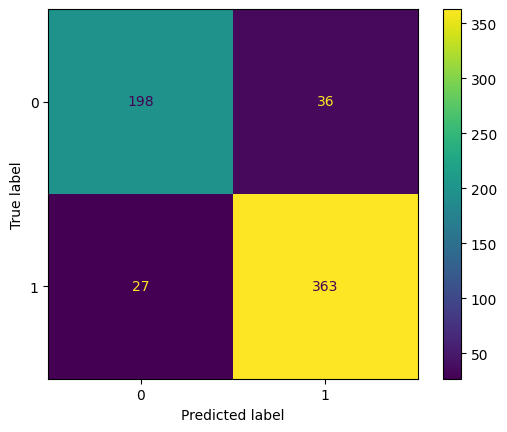

In [36]:
cm = confusion_matrix(y_true,y_pred_alex)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

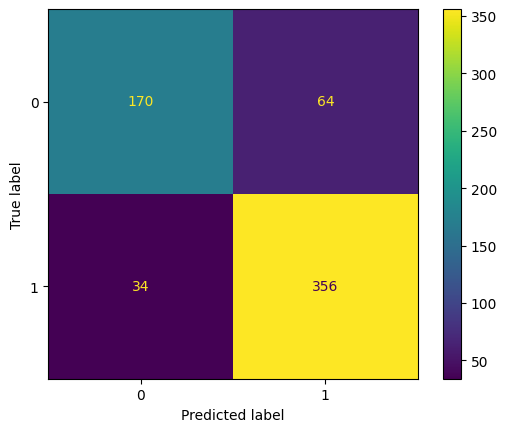

In [45]:
cm = confusion_matrix(y_true,y_pred_vgg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

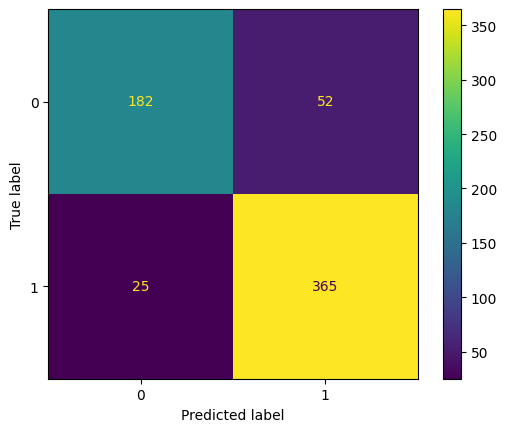

In [46]:
cm = confusion_matrix(y_true,y_pred_resnet)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Save model 

In [18]:
resnet = torch.save(model_resnet.state_dict(),"/kaggle/working/model_resnet.pth")

In [19]:
model = torch.load('/kaggle/working/model_resnet.pth')

In [24]:
import pickle

In [25]:
pickle.dump(model_resnet, open('model.pkl','wb'))


In [26]:
model = pickle.load(open('model.pkl','rb'))


In [27]:
make_prediction(model)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [42]:
all_test_images.shape

torch.Size([624, 3, 224, 224])